In [1]:
import matplotlib.pyplot as plt
import pandas as pd

EVALUATION_FOLDER = "evaluation_minbzk"
RESULTS_FILE = "evaluation_minbzk_no_requests_minbzk_BM25S.csv"
# RESULTS_FILE = "evaluation_minbzk_no_requests_minbzk_keywords_BM25S.csv"
# RESULTS_FILE = "evaluation_minbzk_no_requests_real_words_minbzk_BM25S.csv"
# RESULTS_FILE = "evaluation_minbzk_no_requests_real_words_minbzk_keywords_BM25S.csv"

woo_data = pd.read_csv(f"./{EVALUATION_FOLDER}/results/{RESULTS_FILE}")

In [2]:
true_count = woo_data["dossier#1"].value_counts().get(True, 0)
false_count = woo_data["dossier#1"].value_counts().get(False, 0)
print(f"True: {true_count}, False: {false_count}")

True: 207, False: 34


In [3]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

# Function to process data based on a number of dossiers and threshold
def process_data(num_dossiers):
    results_summary = []
    thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    
    for threshold in thresholds:
        headers = ['dossier_id', 'retrieved_dossier_id', 'confidence', 'result', 'scores']
        df = pd.DataFrame(columns=headers)

        for index, row in woo_data.iterrows():
            dossier_ids = row["retrieved_dossier_ids"].split(", ")[:num_dossiers]  # Limit the number of dossiers
            unique_dossier_ids_set = set(dossier_ids)
            unique_dossier_ids_dict = {key: 0 for key in unique_dossier_ids_set}

            if len(unique_dossier_ids_dict) <= 1:
                result = {key: 1 for key in unique_dossier_ids_dict}
            else:
                for key in unique_dossier_ids_dict:
                    for idx, dossier_id in enumerate(dossier_ids):
                        if key != dossier_id:
                            continue
                        unique_dossier_ids_dict[key] += dossier_ids[0:idx + 1].count(dossier_id)

                result = {key: value / sum(unique_dossier_ids_dict.values()) for key, value in unique_dossier_ids_dict.items()}

            max_key = max(result, key=result.get)
            df.loc[len(df)] = [
                row['dossier_id'],
                max_key,
                result[max_key],
                "N/A" if result[max_key] < threshold else row['dossier_id'] == max_key,
                str(result)
            ]

        true_count = df['result'].value_counts().get(True, 0)
        false_count = df['result'].value_counts().get(False, 0)
        na_count = df['result'].value_counts().get("N/A", 0)

        results_summary.append({
            'Threshold': threshold,
            'True': true_count,
            'False': false_count,
            'N/A': na_count
        })

    # Convert results_summary to DataFrame
    df_summary = pd.DataFrame(results_summary)
    
    # Create a figure and axis for the plot
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Plot the results
    ax.plot(df_summary['Threshold'], df_summary['True'], label='True', marker='o')
    ax.plot(df_summary['Threshold'], df_summary['False'], label='False', marker='o')
    ax.plot(df_summary['Threshold'], df_summary['N/A'], label='N/A', marker='o')
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Count')
    ax.set_title(f'Results Summary for {num_dossiers} Dossiers')
    ax.legend()
    ax.grid(True)
    
    # Display the table and the plot side by side
    with output_table:
        output_table.clear_output(wait=True)
        display(df_summary)
    
    with output_plot:
        output_plot.clear_output(wait=True)
        plt.show()

# Create output widgets for the table and plot
output_table = widgets.Output()
output_plot = widgets.Output()

# Arrange them horizontally in an HBox
hbox = widgets.HBox([output_table, output_plot])

# Display the HBox
display(hbox)

# Interactive widget
dossier_slider = widgets.IntSlider(value=10, min=1, max=50, step=1, description='Dossiers#:')

# Create an interactive display
widgets.interact(process_data, num_dossiers=dossier_slider)


interactive(children=(IntSlider(value=10, description='Dossiers#:', max=50, min=1), Output()), _dom_classes=('…

<function __main__.process_data(num_dossiers)>

In [4]:
import ast
# Based on dossier percentage MAP
dossier_percentage = pd.read_csv("./test.csv")
thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# Index Retrieved Confidence
# a     True      True
# b     True      False
# c     False     True
# d     False     False
results_summary = []

for threshold in thresholds:
    a = 0
    b = 0
    c = 0
    d = 0
    for index, woo_row in woo_data.iterrows():
        matching_rows = dossier_percentage.loc[dossier_percentage['dossier_id'] == woo_row['dossier_id']]
        first_matching_row = matching_rows.iloc[0] if not matching_rows.empty else None


        if matching_rows is None or matching_rows.empty:
            print("[Warning] ~ This should not be possible.")
            continue

        retrieved_dossier_ids = woo_row['retrieved_dossier_ids'].split(", ")
        top_1_dossier = retrieved_dossier_ids[0]
        scores = ast.literal_eval(first_matching_row['scores'])
        # print(list(scores.keys()))
        # print(top_1_dossier)
        # if top_1_dossier not in list(scores.keys()):
        #     print(f"[Warning] ~ {top_1_dossier} is not in scores.")
        #     print("[Warning] ~ This should not be possible.")
        #     continue
        
        if top_1_dossier == woo_row['dossier_id'] and scores[top_1_dossier] >= threshold:
            a += 1
        if top_1_dossier == woo_row['dossier_id'] and scores[top_1_dossier] < threshold:
            b += 1
        if top_1_dossier != woo_row['dossier_id'] and scores[top_1_dossier] >= threshold:
            c += 1
        if top_1_dossier != woo_row['dossier_id'] and scores[top_1_dossier] < threshold:
            d += 1

    results_summary.append({
        'Threshold': threshold,
        'a': a,
        'b': b,
        'c': c,
        'd': d
    })



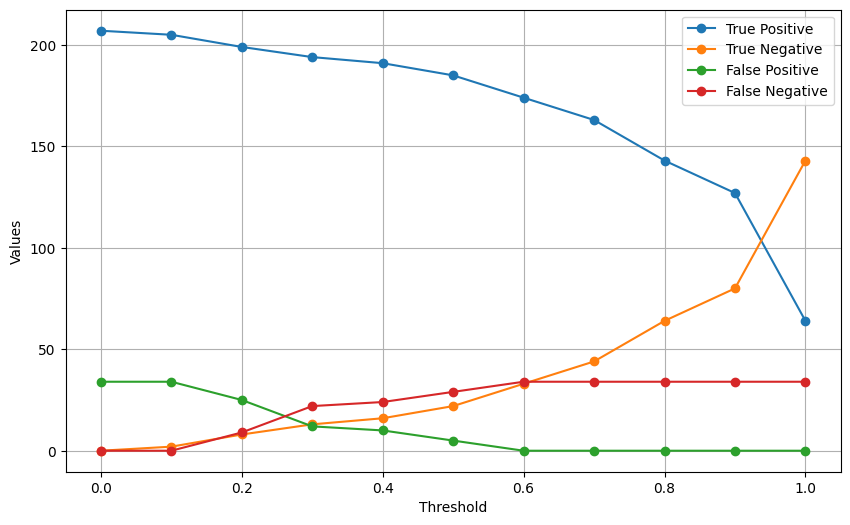

In [6]:
import matplotlib.pyplot as plt

# Data
# data = [{'Threshold': 0.0, 'a': 207, 'b': 0, 'c': 34, 'd': 0},
#         {'Threshold': 0.1, 'a': 205, 'b': 2, 'c': 34, 'd': 0},
#         {'Threshold': 0.2, 'a': 199, 'b': 8, 'c': 25, 'd': 9},
#         {'Threshold': 0.3, 'a': 194, 'b': 13, 'c': 12, 'd': 22},
#         {'Threshold': 0.4, 'a': 191, 'b': 16, 'c': 10, 'd': 24},
#         {'Threshold': 0.5, 'a': 185, 'b': 22, 'c': 5, 'd': 29},
#         {'Threshold': 0.6, 'a': 174, 'b': 33, 'c': 0, 'd': 34},
#         {'Threshold': 0.7, 'a': 163, 'b': 44, 'c': 0, 'd': 34},
#         {'Threshold': 0.8, 'a': 143, 'b': 64, 'c': 0, 'd': 34},
#         {'Threshold': 0.9, 'a': 127, 'b': 80, 'c': 0, 'd': 34},
#         {'Threshold': 1.0, 'a': 64, 'b': 143, 'c': 0, 'd': 34}]

# Extracting data for plotting
thresholds = [item['Threshold'] for item in results_summary]
a_values = [item['a'] for item in results_summary]
b_values = [item['b'] for item in results_summary]
c_values = [item['c'] for item in results_summary]
d_values = [item['d'] for item in results_summary]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, a_values, marker='o', label='True Positive')
plt.plot(thresholds, b_values, marker='o', label='True Negative')
plt.plot(thresholds, c_values, marker='o', label='False Positive')
plt.plot(thresholds, d_values, marker='o', label='False Negative')

plt.xlabel('Threshold')
plt.ylabel('Values')
# plt.title('Values vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()


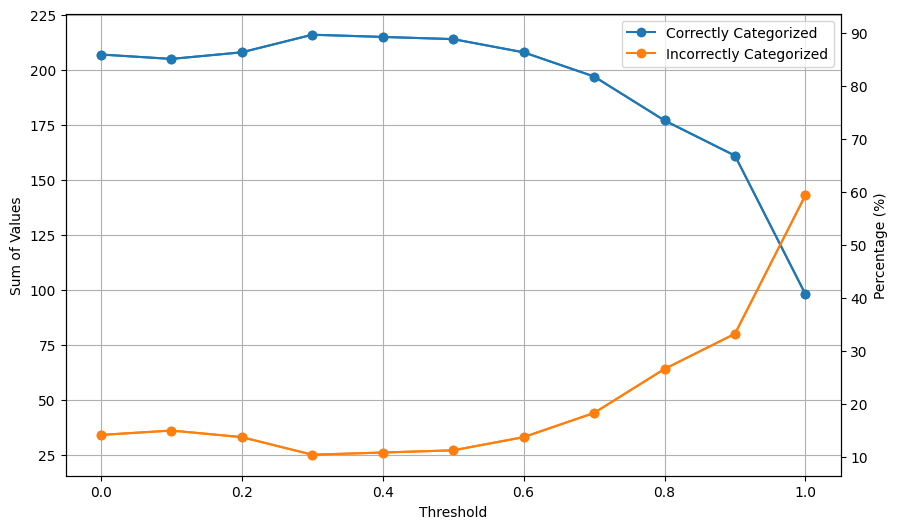

In [7]:
# Calculating the sum of 'a' + 'd' and 'b' + 'c'
a_d_sum = [item['a'] + item['d'] for item in results_summary]
b_c_sum = [item['b'] + item['c'] for item in results_summary]

# Calculating the total sum of 'a', 'b', 'c', and 'd' for each threshold
total_sum = [item['a'] + item['b'] + item['c'] + item['d'] for item in results_summary]

# Calculating the percentages for 'a+d' and 'b+c'
a_d_percent = [100 * (ad / total) for ad, total in zip(a_d_sum, total_sum)]
b_c_percent = [100 * (bc / total) for bc, total in zip(b_c_sum, total_sum)]

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(thresholds, a_d_sum, marker='o', label='Correctly Categorized')
ax1.plot(thresholds, b_c_sum, marker='o',  label='Incorrectly Categorized')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Sum of Values')
ax1.grid(True)

# Creating a secondary y-axis for the percentage
ax2 = ax1.twinx()
ax2.plot(thresholds, a_d_percent, marker='o')
ax2.plot(thresholds, b_c_percent, marker='o')
ax2.set_ylabel('Percentage (%)')

fig.legend(bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()
